In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import time
import seaborn as sn
from sklearn import *
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [3]:
dataPi = pd.read_csv('/Users/edouardnadaud/Desktop/DATACAMP_PYTHON_2/Dataset/trainset/trainset.csv')

On doit utiliser le dataset train pour tester les résultats étant donné que dans le dataset test il n'y a pas les labels.

In [4]:
X_dataPi = dataPi[dataPi.columns[1:-1]]
y_dataPi = dataPi[dataPi.columns[-1]]

## Mais pourquoi? Commençons par étudier la répartission des données:

In [5]:
emotions = {0:"neutre", 1:"colère", 3:"dégoût", 4:"peur", 5:"joie", 6:"tristesse", 7:"surprise"}
print("Il y a ", dataPi.shape[0] , "exemples en tout dans le dataset dont :")
[print ( dataPi[dataPi['label'] == a].shape[0], "exemples d'images de classe",a,"(",emotions[a],")") for a in np.sort(dataPi['label'].unique())];

Il y a  722 exemples en tout dans le dataset dont :
473 exemples d'images de classe 0 ( neutre )
34 exemples d'images de classe 1 ( colère )
50 exemples d'images de classe 3 ( dégoût )
17 exemples d'images de classe 4 ( peur )
55 exemples d'images de classe 5 ( joie )
23 exemples d'images de classe 6 ( tristesse )
70 exemples d'images de classe 7 ( surprise )


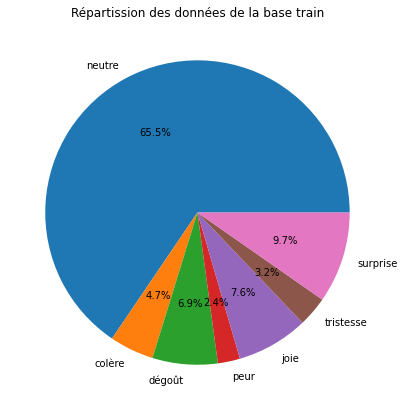

In [6]:
plt.figure(figsize=(7,7))
plt.title("Répartission des données de la base train")
plt.pie([ dataPi[dataPi['label'] == a].shape[0] for a in np.sort(dataPi['label'].unique())], autopct='%1.1f%%',labels=emotions.values());

### Comme nous le voyons ici les classes de notre base de test ont des données très inégalement réparties. Comment faire pour résoudre ce problème? Nous devons effectuer des recherches.

# Apprentissage déséquilibré ou  imbalenced learning


### Bibliographie:

### <i> Machine Learning from Imbalanced Data Sets 101</i>, Foster Provost, NY University
#### https://www.aaai.org/Papers/Workshops/2000/WS-00-05/WS00-05-001.pdf

### <i>Learning from imbalanced data: open challenges and future directions</i>, Bartosz Krawczyk, Wrocław University of Technology
#### https://link.springer.com/article/10.1007/s13748-016-0094-0?TB_iframe=true&error=cookies_not_supported&code=a3e33168-782e-41e5-8585-e731754069d2

### <i>Imbalenced Learning</i>, Haibo He & Yunqian Ma
#### https://books.google.fr/books?hl=fr&lr=&id=CVHx-Gp9jzUC&oi=fnd&pg=PT9&dq=machine+learning+imbalanced+data&ots=2iLmIhzp5g&sig=vMMBD-6KVEKXxjOeFA8pPd6B3rI#v=onepage&q=machine%20learning%20imbalanced%20data&f=false

https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

### Ajinkya More | Resampling techniques and other strategies
#### https://www.youtube.com/watch?v=-Z1PaqYKC1w

In [7]:
import math




def dist(point1, point2, df):
    point1, point2 = str(point1), str(point2)
    return  (  (df[' x_' + point2] - df[' x_' + point1])**(2) +  (df[' y_' + point2] - df[' y_' + point1])**(2)   )**(0.5)

def dist_normalisee(point1, point2, df, coef): # normalisée par la distance interoculaire
    point1, point2 = str(point1), str(point2)
    return  (((  (df[' x_' + point2] - df[' x_' + point1])**(2) +  (df[' y_' + point2] - df[' y_' + point1])**(2)   )**(0.5))/coef)

def angl(point1, point2, point3, df):
    point1, point2, point3 = str(point1), str(point2), str(point3)
    a = np.array([df[' x_' + point1],df[' y_' + point1]])
    b = np.array([df[' x_' + point2],df[' y_' + point2]])
    c = np.array([df[' x_' + point3],df[' y_' + point3]])
    
    angle = np.degrees(np.arctan(c[1]-b[1], c[0]-b[0]) - np.arctan(a[1]-b[1], a[0]-b[0]))
 
    angle[angle<0] = angle[angle<0] + 360
    return angle


In [8]:
from sklearn.preprocessing import StandardScaler
X_new_ft = X_dataPi.copy()

X_new_ft['distOculaire'] = (  (X_new_ft.loc[: , " x_42":" x_47"].mean(axis=1) - X_new_ft.loc[: , " x_36":" x_41"].mean(axis=1))**(2) +  (X_new_ft.loc[: , " y_42":" y_47"].mean(axis=1) - X_new_ft.loc[: , " y_36":" y_41"].mean(axis=1))**(2)   )**(0.5)


for i in range(0,68):
    for j in range(i,68): # afin de ne pas recalculer deux fois la meme distance
        if (i != j): # on ne calcule pas la distance d'un point avec lui même
            #X_new_ft['dist'+str(i)+"_"+str(j)]  = dist(i, j, X_dataPi)
            X_new_ft['dist_norm'+str(i)+"_"+str(j)]  = dist_normalisee(i, j, X_dataPi,X_new_ft['distOculaire'])

for i in range(0,68):
    for j in range(0,68): # afin de ne pas recalculer deux fois le même angle
        for k in range(i,68):
            if (i != j and j != k and i != k): # on ne calcule pas d'angle entre 3 points quand deux d'entre eux sont les mêmes             
                X_new_ft['angl'+str(i)+"_"+str(j)+"_"+str(k)] = angl(i, j, k, X_dataPi)
    print('clacul pour les angles a=',i)

X_new_ft.drop(X_new_ft.iloc[:, 0:137], inplace = True, axis = 1) 

ColonnesDf = X_new_ft.columns
indexDf = X_new_ft.index
standardScaler = StandardScaler()
X_new_ft = standardScaler.fit_transform(X_new_ft)

X_new_ft = pd.DataFrame(X_new_ft, index=indexDf, columns=ColonnesDf)

X_nf_train, X_nf_test, y_dataPiTrain, y_dataPiTest = model_selection.train_test_split(X_new_ft, y_dataPi, train_size=0.75, test_size=0.25,shuffle=False)

clacul pour les angles a= 0
clacul pour les angles a= 1
clacul pour les angles a= 2
clacul pour les angles a= 3
clacul pour les angles a= 4
clacul pour les angles a= 5
clacul pour les angles a= 6
clacul pour les angles a= 7
clacul pour les angles a= 8
clacul pour les angles a= 9
clacul pour les angles a= 10
clacul pour les angles a= 11
clacul pour les angles a= 12
clacul pour les angles a= 13
clacul pour les angles a= 14
clacul pour les angles a= 15
clacul pour les angles a= 16
clacul pour les angles a= 17
clacul pour les angles a= 18
clacul pour les angles a= 19
clacul pour les angles a= 20
clacul pour les angles a= 21
clacul pour les angles a= 22
clacul pour les angles a= 23
clacul pour les angles a= 24
clacul pour les angles a= 25
clacul pour les angles a= 26
clacul pour les angles a= 27
clacul pour les angles a= 28
clacul pour les angles a= 29
clacul pour les angles a= 30
clacul pour les angles a= 31
clacul pour les angles a= 32
clacul pour les angles a= 33
clacul pour les angles a

In [9]:
from sklearn.model_selection import GridSearchCV
parameters = { 'n_neighbors':[1,2,3],'weights':['uniform','distance'],'metric':['euclidean','manhattan']}
#svc = svm.SVC()
#knnModel = KNeighborsClassifier()
gscv = GridSearchCV(KNeighborsClassifier(), parameters,verbose=1,cv=3,n_jobs = -1)
gsres = gscv.fit(X_nf_train, y_dataPiTrain)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
best score 0.8208103130755063 best estimator KNeighborsClassifier(metric='manhattan', n_neighbors=3) best params {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


0.8176795580110497


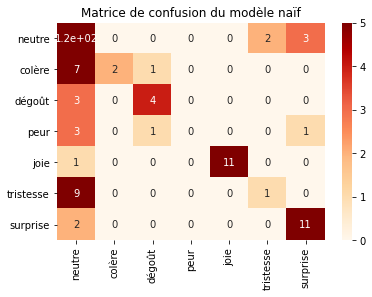

In [10]:
knnModels = []
KnnResultsTest = []
KnnResultsTrain = []

knnModel = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
knnModel.fit(X_nf_train,y_dataPiTrain)
print(knnModel.score(X_nf_test,y_dataPiTest))

yPredicted=knnModel.predict(X_nf_test)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle naïf");

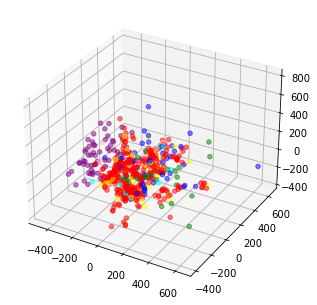

In [11]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)

pca.fit(X_nf_train)

XPCA = pca.transform(X_nf_train)

XPCADf = pd.DataFrame(data = XPCA, columns = ['pc1', 'pc2', 'pc3'])
colors = {0:'red', 1:'green', 3:'blue', 4:'pink',5:'yellow', 6:'cyan', 7:'purple'}
fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(XPCADf.pc1, XPCADf.pc2, XPCADf.pc3, c=y_dataPiTrain.map(colors),alpha=0.5);


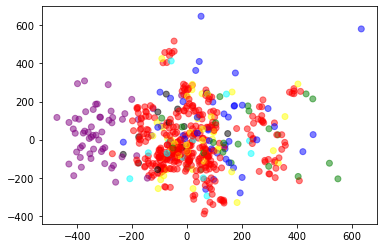

In [12]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=2)

pca.fit(X_nf_train)

XPCA = pca.transform(X_nf_train)

XPCADf = pd.DataFrame(data = XPCA, columns = ['pc1', 'pc2'])
colors = {0:'red', 1:'green', 3:'blue', 4:'black',5:'yellow', 6:'cyan', 7:'purple'}
fig = plt.figure()
plt.scatter(XPCADf.pc1, XPCADf.pc2, c=y_dataPiTrain.map(colors),alpha=0.5);

## Apprentissage Non supervise


-16249235.782330997


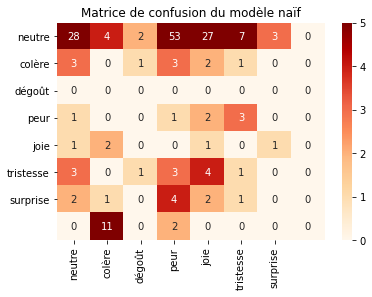

In [13]:
from sklearn.cluster import KMeans
knnModels = []
KnnResultsTest = []
KnnResultsTrain = []

knnModel = KMeans(n_clusters=7, algorithm='auto')
knnModel.fit(X_nf_train,y_dataPiTrain)
print(knnModel.score(X_nf_test,y_dataPiTest))

yPredicted=knnModel.predict(X_nf_test)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle naïf");

In [14]:
'''clf = MLPClassifier(hidden_layer_sizes=(20,20),max_iter=500, activation='tanh', solver='sgd', batch_size=1, alpha=0, learning_rate='adaptive', verbose=0)
clf.fit(X_nf_train,y_dataPiTrain)
print(clf.score(X_nf_test,y_dataPiTest))
yPredicted=clf.predict(X_nf_test)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle naïf");'''

'clf = MLPClassifier(hidden_layer_sizes=(20,20),max_iter=500, activation=\'tanh\', solver=\'sgd\', batch_size=1, alpha=0, learning_rate=\'adaptive\', verbose=0)\nclf.fit(X_nf_train,y_dataPiTrain)\nprint(clf.score(X_nf_test,y_dataPiTest))\nyPredicted=clf.predict(X_nf_test)\nmatriceConfusion = metrics.confusion_matrix(y_dataPiTest,yPredicted)\nsn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());\nplt.title("Matrice de confusion du modèle naïf");'

In [17]:
#rapportDeResampling(X_nf_train, y_dataPiTrain,X_nf_test, y_dataPiTest,DecisionTreeClassifier(class_weight='balanced'),emotions.values() )

NameError: name 'rapportDeResampling' is not defined

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
X_nf_train_copy = X_nf_train.copy()

X_nf_train_copy = MinMaxScaler().fit_transform(X_nf_train_copy)
X_nf_train_copy = pd.DataFrame(X_nf_train_copy, index=X_nf_train.index, columns=ColonnesDf)

In [22]:
X_nf_train_copy.head(2)

,dist_norm0_1,dist_norm0_2,dist_norm0_3,dist_norm0_4,dist_norm0_5,dist_norm0_6,dist_norm0_7,dist_norm0_8,dist_norm0_9,dist_norm0_10,...,angl66_56_67,angl66_57_67,angl66_58_67,angl66_59_67,angl66_60_67,angl66_61_67,angl66_62_67,angl66_63_67,angl66_64_67,angl66_65_67
0,0.437178,0.431541,0.410714,0.362606,0.320953,0.300341,0.306108,0.342681,0.397669,0.495156,...,0.999793,0.999828,0.999810,0.999680,0.970301,0.990414,0.986730,0.994886,0.951637,0.958283
1,0.218744,0.240248,0.232076,0.206114,0.171300,0.152122,0.147440,0.168660,0.205146,0.274179,...,0.999764,0.999809,0.999783,0.999589,0.893206,0.995287,0.993884,0.996516,0.959707,0.965475


In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=100)
bestfeatures = bestfeatures.fit(X_nf_train_copy,y_dataPiTrain)
dfscores = pd.DataFrame(bestfeatures.scores_)
dfcolumns = pd.DataFrame(X_nf_train_copy.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.sort_values("Score",ascending=False, inplace = True) 
featureScores[0:100]

,Specs,Score
143456,angl50_55_66,151.721187
144524,angl51_55_66,151.429634
142322,angl49_55_66,151.426971
145526,angl52_55_66,148.776069
148248,angl55_66_56,147.536194
...,...,...
50324,angl11_55_66,109.723287
27086,angl5_55_66,108.886498
144543,angl51_57_54,107.384404
144558,angl51_58_54,106.221518


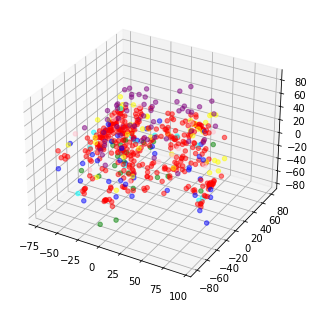

In [24]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
pca.fit(X_nf_train_copy)

XPCA = pca.transform(X_nf_train_copy)
XPCADf = pd.DataFrame(data = XPCA, columns = ['pc1', 'pc2', 'pc3'])
colors = {0:'red', 1:'green', 3:'blue', 4:'pink',5:'yellow', 6:'cyan', 7:'purple'}


fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(XPCADf.pc1, XPCADf.pc2, XPCADf.pc3, c=y_dataPiTrain.map(colors),alpha=0.5);

In [25]:
from imblearn.over_sampling import ADASYN
X_new_ft_PCA = X_new_ft.copy()

pca = PCA(n_components=722)
pca.fit(X_new_ft_PCA)
XPCA = pca.transform(X_new_ft_PCA)

In [26]:
X_nf_train_pca, X_nf_test_pca, y_dataPiTrain_pca, y_dataPiTest_pca = model_selection.train_test_split(XPCA, y_dataPi, train_size=0.75, test_size=0.25,shuffle=True)
X_nf_train_pca, y_dataPiTrain_pca = ADASYN().fit_resample(X_nf_train_pca,y_dataPiTrain_pca)

0.8232044198895028


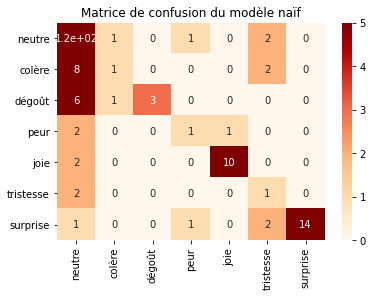

In [27]:
knnModels = []
KnnResultsTest = []
KnnResultsTrain = []

knnModel = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 1, weights= 'uniform')
knnModel.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(knnModel.score(X_nf_test_pca,y_dataPiTest_pca))

yPredicted=knnModel.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle naïf");

In [28]:
print(classification_report(y_dataPiTest_pca,yPredicted,zero_division=0))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       123
           1       0.33      0.09      0.14        11
           3       1.00      0.30      0.46        10
           4       0.33      0.25      0.29         4
           5       0.91      0.83      0.87        12
           6       0.14      0.33      0.20         3
           7       1.00      0.78      0.88        18

    accuracy                           0.82       181
   macro avg       0.65      0.51      0.53       181
weighted avg       0.82      0.82      0.80       181



In [29]:
from sklearn.model_selection import GridSearchCV
parameters = { 'n_neighbors':range(1,10),'weights':['uniform','distance'],'metric':['minkowski','euclidean','manhattan']}
#svc = svm.SVC()
#knnModel = KNeighborsClassifier()
gscv = GridSearchCV(KNeighborsClassifier(), parameters,verbose=1,cv=5,n_jobs = -1, scoring='f1_micro')
gsres = gscv.fit(X_nf_train_pca,y_dataPiTrain_pca)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
best score 0.9894226152037489 best estimator KNeighborsClassifier(metric='manhattan', n_neighbors=1) best params {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [30]:
from sklearn.tree import DecisionTreeClassifier
parameters = { 'criterion':['gini', 'entropy'],'max_depth':range(1,722,50)}
gscv = GridSearchCV(DecisionTreeClassifier(), parameters,verbose=1,cv=5,n_jobs = -1, scoring='f1_micro')
gsres = gscv.fit(X_nf_train_pca,y_dataPiTrain_pca)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best score 0.8807618432599804 best estimator DecisionTreeClassifier(max_depth=701) best params {'criterion': 'gini', 'max_depth': 701}


0.7182320441988951


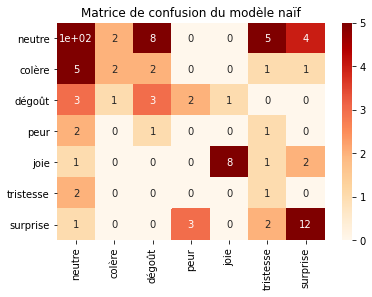

In [31]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 422)
clf.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(clf.score(X_nf_test_pca,y_dataPiTest_pca))

yPredicted=clf.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle naïf");

In [32]:
from sklearn.ensemble import RandomForestClassifier
parameters = { 'n_estimators':range(1,300,50),'max_depth':range(1,722,100),'criterion':['gini', 'entropy']}
gscv = GridSearchCV(RandomForestClassifier(), parameters,verbose=1,cv=5,n_jobs = -1, scoring='f1_micro')
gsres = gscv.fit(X_nf_train_pca,y_dataPiTrain_pca)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
best score 0.993492623317272 best estimator RandomForestClassifier(max_depth=301, n_estimators=251) best params {'criterion': 'gini', 'max_depth': 301, 'n_estimators': 251}


0.7900552486187845


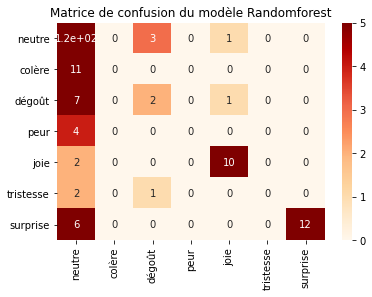

In [82]:
clf = RandomForestClassifier(criterion='gini',n_estimators=201, max_depth = 401)
clf.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(clf.score(X_nf_test_pca,y_dataPiTest_pca))

yPredicted=clf.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle Randomforest");

In [95]:
from sklearn.svm import LinearSVC
parameters = { 'penalty':['l1', 'l2'],'dual':[True, False],'C':np.arange(0.1, 5, 0.5)}
gscv = GridSearchCV(LinearSVC(), parameters,verbose=1,cv=5,n_jobs = -1, scoring='f1_micro')
gsres = gscv.fit(X_nf_train_pca,y_dataPiTrain_pca)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

0.8950276243093923


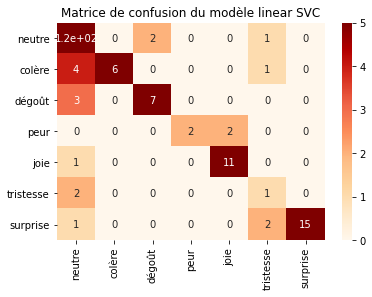

In [81]:
clf = LinearSVC(C=0.1, penalty='l1',dual = False,max_iter=20000) 
clf.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(clf.score(X_nf_test_pca,y_dataPiTest_pca))

yPredicted=clf.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle linear SVC");

In [36]:
print(classification_report(y_dataPiTest_pca,yPredicted,zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.98      0.94       123
           1       1.00      0.55      0.71        11
           3       0.78      0.70      0.74        10
           4       1.00      0.50      0.67         4
           5       0.85      0.92      0.88        12
           6       0.20      0.33      0.25         3
           7       1.00      0.83      0.91        18

    accuracy                           0.90       181
   macro avg       0.82      0.69      0.73       181
weighted avg       0.91      0.90      0.89       181



In [72]:
from sklearn.svm import NuSVC
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'nu':np.arange(0, 1, 0.3),'gamma':['scale', 'auto']}
gscv = GridSearchCV(NuSVC(), parameters,verbose=10,cv=5,n_jobs = -1, scoring='f1_micro')
gsres = gscv.fit(X_nf_train_pca,y_dataPiTrain_pca)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/edouardnadaud/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.94711722 0.89300664 0.78353203        nan 0.90968986
 0.78185882 0.45338036        nan 0.9576888  0.89095756 0.78718146
        nan 0.86123889 0.85636663 0.7827124         nan 0.94711722
 0.89300664 0.78353203        nan 0.90968986 0.78185882 0.45338036
        nan 0.48999553 0.48836869 0.40860282        nan 0.34714122
 0.3927831  0.5445896 ]
  warnings.warn(


best score 0.9576888049939563 best estimator NuSVC(nu=0.3) best params {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.3}


#### Il y a quelques erreurs qui ne sont pas vraiment problématiques, elles correspondent au fait que le F1 score peut donner des scores négatifs, ce qui peut être mal géré, comme expliqué dans l'article suivant: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [73]:
from sklearn.svm import SVC
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':np.arange(0, 3, 0.5),'gamma':['scale', 'auto']}
gscv = GridSearchCV(SVC(), parameters,verbose=1,cv=5,n_jobs = -1, scoring='f1_micro')
gsres = gscv.fit(X_nf_train_pca,y_dataPiTrain_pca)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/edouardnadaud/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan 0.99755766 0.86938139 0.96460765 0.84252397
 0.99755766 0.98250625 0.30807047 0.33576408 0.99755766 0.90560413
 0.98413475 0.82827314 0.99755766 0.98250625 0.47168463 0.32886096
 0.99755766 0.92147517 0.98983078 0.82420231 0.99755766 0.98250625
 0.4895882  0.33211299 0.99755766 0.94222675 0.99268044 0.818498
 0.99755766 0.98250625 0.4895882  0.33699601 0.99755766 0.95402365
 0.99268044 0.81402563 0.99755766 0.98250625 0.4895882  0.33618631]
  warnings.warn(


best score 0.9975576639676783 best estimator SVC(C=0.5, kernel='linear') best params {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}


0.9060773480662984


Text(0.5, 1.0, 'Matrice de confusion du modèle SVC')

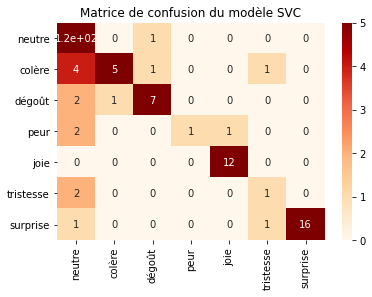

In [80]:
from sklearn.svm import SVC
clf = SVC(C=0.5, kernel='linear',max_iter=20000) 
clf.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(clf.score(X_nf_test_pca,y_dataPiTest_pca))

yPredicted=clf.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle SVC")

In [74]:
from sklearn.neural_network import MLPClassifier
parameters = {'hidden_layer_sizes':[(20),(100),(20,20),(20,20,20),(100,100), (100,100,100),(200),(200,200),(200,200,200)]}
gscv = GridSearchCV(MLPClassifier(), parameters,verbose=1,cv=5,n_jobs = -1, scoring='f1_micro')
gsres = gscv.fit(X_nf_train_pca,y_dataPiTrain_pca)
print("best score",gsres.best_score_, "best estimator",gsres.best_estimator_, "best params", gsres.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best score 0.9902372791548689 best estimator MLPClassifier(hidden_layer_sizes=200) best params {'hidden_layer_sizes': 200}


0.856353591160221


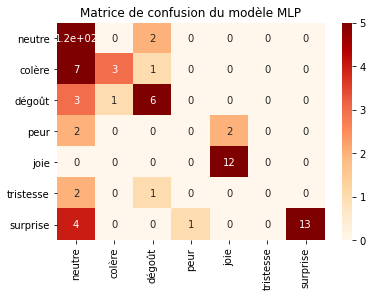

In [77]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200,200 )) 
clf.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(clf.score(X_nf_test_pca,y_dataPiTest_pca))

yPredicted=clf.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle MLP");

In [78]:
classifier = LogisticRegressionCV(cv=20, n_jobs=-1)
classifier.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(classifier.score(X_nf_test_pca,y_dataPiTest_pca))

0.9005524861878453


/Users/edouardnadaud/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


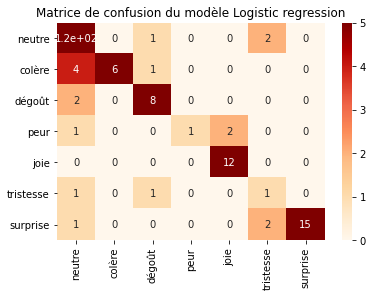

In [79]:
yPredicted=classifier.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle Logistic regression");

# VOTING CLASSIFIER

In [83]:
from sklearn.ensemble import VotingClassifier
model1=SVC(C=0.5, kernel='linear',max_iter=20000) 
model2=MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200,200 )) 
model3=LinearSVC(C=0.1, penalty='l1',dual = False,max_iter=20000) 
model4=LogisticRegressionCV(cv=20, n_jobs=-1)
model5= VotingClassifier([('SVC',model1),
                           ('MLPClassifier',model2),
                           ('LinearSVC',model3)],
                             voting='hard')

for model in (model1,model2,model3,model4,model5):
    model.fit(X_nf_train_pca,y_dataPiTrain_pca)
    print(model.score(X_nf_test_pca,y_dataPiTest_pca))

0.9060773480662984
0.8839779005524862
0.8950276243093923


/Users/edouardnadaud/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9005524861878453
0.8950276243093923


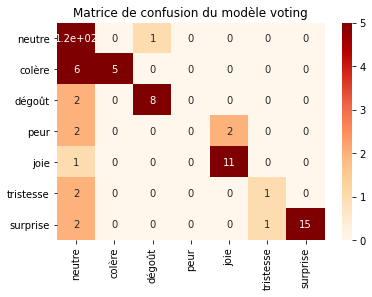

In [84]:
yPredicted=model.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle voting");

# BAGGING 

pour des model singulier avec de l'over fitting

In [85]:
from sklearn.ensemble import BaggingClassifier

In [86]:
modelbaggin=BaggingClassifier(SVC(C=0.5, kernel='linear',max_iter=20000) ,n_estimators=5)
modelbaggin.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(modelbaggin.score(X_nf_test_pca,y_dataPiTest_pca))

0.8950276243093923


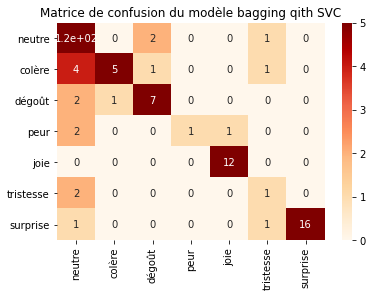

In [87]:
yPredicted=modelbaggin.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle bagging with SVC");

In [88]:
modelbaggin=BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth = 422),n_estimators=200)
modelbaggin.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(modelbaggin.score(X_nf_test_pca,y_dataPiTest_pca))

0.7790055248618785


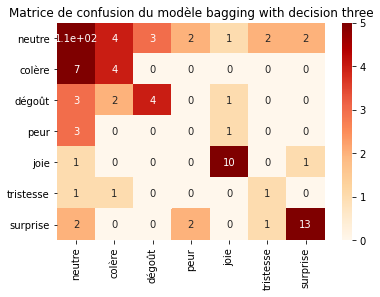

In [89]:
yPredicted=modelbaggin.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle bagging with decision three");

avantage des decisionTree= vitesse d'execution et d'entrainement


# BOOSTING

In [90]:
from sklearn.ensemble import  AdaBoostClassifier

In [91]:
modelboosting=AdaBoostClassifier(n_estimators=1000)
modelboosting.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(modelboosting.score(X_nf_test_pca,y_dataPiTest_pca))

0.4419889502762431


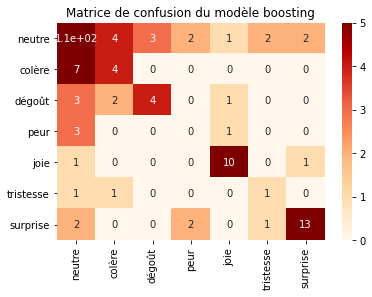

In [92]:
yPredicted=modelbaggin.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle boosting");

# Stacking

Si on a des models individuel tres entrainée

In [93]:
from sklearn.ensemble import StackingClassifier
modelstacking= StackingClassifier([('SVC',model1),
                           ('MLPClassifier',model2),
                           ('LinearSVC',model3)],
                         final_estimator=DecisionTreeClassifier())
modelstacking.fit(X_nf_train_pca,y_dataPiTrain_pca)
print(modelstacking.score(X_nf_test_pca,y_dataPiTest_pca))

0.861878453038674


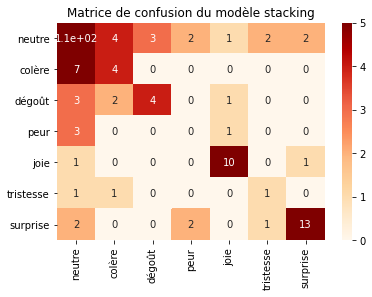

In [94]:
yPredicted=modelbaggin.predict(X_nf_test_pca)
matriceConfusion = metrics.confusion_matrix(y_dataPiTest_pca,yPredicted)
sn.heatmap(matriceConfusion, annot=True,cmap="OrRd",vmax = 5,xticklabels = emotions.values(),yticklabels = emotions.values());
plt.title("Matrice de confusion du modèle stacking");